In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalMaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

In [2]:
df = pd.read_csv('../data/Subset-Chexchonet/subset_labels.csv')
df['cxr_path'] = '../data/Subset-Chexchonet/images/' + df['cxr_filename']
# Create a new column 'label' for binary classification (slvh = 1 or dlv = 1 -> label = 1)
df['label'] = df[['slvh', 'dlv']].max(axis=1)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
train_df, val_df  = train_test_split(train_df, test_size=0.1, stratify=train_df["label"], random_state=42)

In [41]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
EPOCH = 20

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col="cxr_path",
    y_col="label",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw"
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="cxr_path",
    y_col="label",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw"
)

test_gen = val_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="cxr_path",
    y_col="label",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=False
)

Found 720 validated image filenames.
Found 80 validated image filenames.
Found 200 validated image filenames.


In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.summary()

c:\Users\Phi Yen\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model

In [37]:
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze the base model
# base_model.summary()

In [38]:
model = Sequential([
    base_model,
    GlobalMaxPooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

In [39]:
model.compile(optimizer=Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.AUC()])

In [31]:
earlystop =  EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('../best_model.keras', monitor='val_loss', save_best_only=True)

In [45]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Tính weight cho train set
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["label"]),
    y=train_df["label"]
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: 0.5732484076433121, 1: 3.9130434782608696}


In [46]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCH,
    callbacks=[earlystop, checkpoint]
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 713ms/step - accuracy: 0.8660 - auc: 0.5850 - loss: 0.4062 - val_accuracy: 0.8750 - val_auc: 0.5636 - val_loss: 0.3781
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 717ms/step - accuracy: 0.8707 - auc: 0.5752 - loss: 0.4071 - val_accuracy: 0.8750 - val_auc: 0.5671 - val_loss: 0.3782
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 715ms/step - accuracy: 0.8679 - auc: 0.6344 - loss: 0.3909 - val_accuracy: 0.8750 - val_auc: 0.5136 - val_loss: 0.3876
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 706ms/step - accuracy: 0.8766 - auc: 0.6067 - loss: 0.3749 - val_accuracy: 0.8750 - val_auc: 0.5071 - val_loss: 0.3861
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 706ms/step - accuracy: 0.8743 - auc: 0.6200 - loss: 0.3734 - val_accuracy: 0.8750 - val_auc: 0.5064 - val_loss: 0.3901
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 711ms/step - accuracy: 0.8645 - auc: 0.6720 - loss: 0.3690 - val_accuracy: 0.8750 - val_auc: 0.5257 - val_loss: 0.3897


In [57]:
y_val_pred = model.predict(val_gen)
y_val_true = val_df['label'].values  # hoặc val_gen.labels nếu có

# 3. Tìm threshold tối ưu (theo ROC)
fpr, tpr, thresholds = roc_curve(y_val_true, y_val_pred)
youden_idx = np.argmax(tpr - fpr)   # maximize sensitivity+specificity
best_thresh = thresholds[youden_idx]
print("Best threshold (ROC):", best_thresh)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 493ms/step
Best threshold (ROC): 0.039374013


In [59]:
y_pred = model.predict(test_gen).ravel() 
y_true = test_df['label'].values

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 564ms/step


In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

Test AUC: 0.6514146772767463


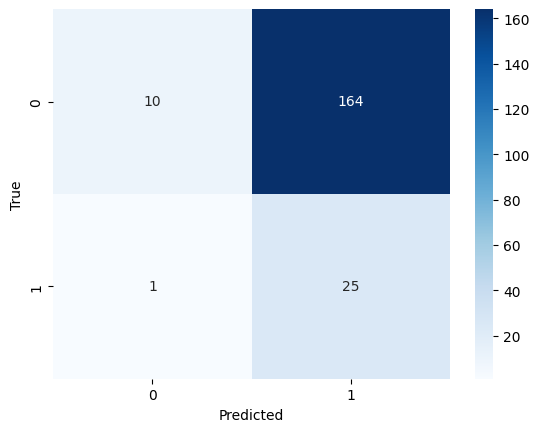

In [61]:
# ROC & AUC
auc = roc_auc_score(y_true, y_pred)
print("Test AUC:", auc)

# Confusion Matrix
y_pred_class = (y_pred > best_thresh).astype(int)
cm = confusion_matrix(y_true, y_pred_class)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


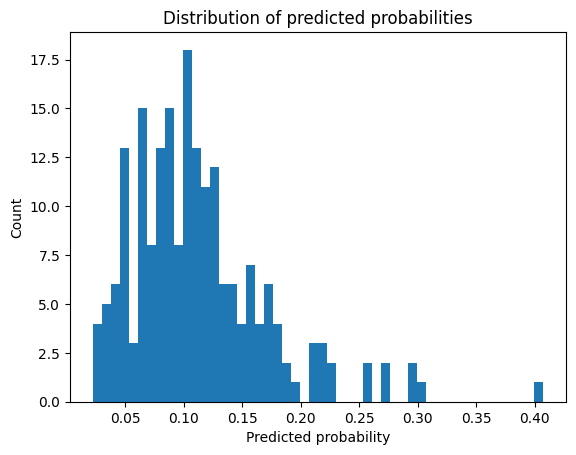

In [62]:
import matplotlib.pyplot as plt

plt.hist(y_pred, bins=50)
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.title("Distribution of predicted probabilities")
plt.show()